In [100]:
import os
import pandas
import numpy as np
import nibabel as ni
from glob import glob
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn import image, input_data, plotting, datasets
from sklearn import linear_model, model_selection, cross_decomposition, decomposition, ensemble, svm
from sklearn.metrics import mean_absolute_error

In [90]:
%matplotlib inline

# Get metadata

In [84]:
df = pandas.read_csv('/data1/users/jvogel/PAC2019/PAC_Data/PAC2019_BrainAge_Training.csv',
                    index_col=0)
df.head()

,age,gender,site
subject_ID,,,
sub2609,41.0,m,13
sub1670,19.0,f,2
sub2717,55.0,m,7
sub358,27.0,m,2
sub2949,22.0,m,3


# Extract features

In [6]:
# find GM images
gms = sorted(glob('/data1/users/jvogel/PAC2019/PAC_Data/gm/*.nii.gz'))
len(gms)

2640

In [14]:
# Initiate atlases
basc = datasets.atlas.fetch_atlas_basc_multiscale_2015()
atlases = {}
for scale in basc.__dir__():
    if 'scale' in scale:
        atlases.update({scale: getattr(basc,scale)})

In [24]:
# get feature names
feature_names = []
for scale, atlas in atlases.items():
    unique_labels = np.unique(ni.load(atlas).get_data())
    feature_names += ["{}_{}".format(scale,int(i)) for i in unique_labels[1:]] # don't grab background
print('{} features in total'.format(len(features)))

1227 features in total


In [30]:
# build results dataframe
subs = df.index
features = pandas.DataFrame(index = subs, columns = feature_names)
features.head()

,scale007_1,scale007_2,scale007_3,scale007_4,scale007_5,scale007_6,scale007_7,scale012_1,scale012_2,scale012_3,...,scale444_435,scale444_436,scale444_437,scale444_438,scale444_439,scale444_440,scale444_441,scale444_442,scale444_443,scale444_444
subject_ID,,,,,,,,,,,,,,,,,,,,,
sub2609,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub1670,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub2717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub358,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sub2949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [69]:
# find batch size
for i in range(90,150):
    if len(gms)%i == 0:
        print('A batch size of {} would result in {} batches'.format(i,len(gms)/i))

A batch size of 110 would result in 24.0 batches
A batch size of 120 would result in 22.0 batches
A batch size of 132 would result in 20.0 batches


In [78]:
len(batch)

132

In [79]:
## Extract data (this takes a long time)

batch_size = 132
n_batches = int(len(gms) / batch_size)

for scale, atlas in atlases.items():
    print('working on',scale)
    mskr = input_data.NiftiLabelsMasker(atlas)
    cols = [x for x in features.columns if scale in x]
    for i in range(1,n_batches+1):
        print('working on batch {} of {}'.format(i,n_batches+1))
        batch_range = (132 * (i-1)) + np.array(range(132))
        batch = np.array(gms)[batch_range]
        sids = [os.path.split(gm)[-1].split('_gm')[0] for gm in batch]
        if not all([x in df.index for x in sids]):
            print(['>']*10,'missing subject in batch',i,['<']*10)
            continue
        imgs = image.load_img(batch)
        data = mskr.fit_transform(imgs)
        features.loc[sids, cols] = data
        features.to_csv('BASC_Features_GMDerivatives.csv')

working on scale007
working on batch 1 of 21
working on batch 2 of 21
working on batch 3 of 21
working on batch 4 of 21
working on batch 5 of 21
working on batch 6 of 21
working on batch 7 of 21
working on batch 8 of 21
working on batch 9 of 21
working on batch 10 of 21
working on batch 11 of 21
working on batch 12 of 21
working on batch 13 of 21
working on batch 14 of 21
working on batch 15 of 21
working on batch 16 of 21
working on batch 17 of 21
working on batch 18 of 21
working on batch 19 of 21
working on batch 20 of 21
working on scale012
working on batch 1 of 21
working on batch 2 of 21
working on batch 3 of 21
working on batch 4 of 21
working on batch 5 of 21
working on batch 6 of 21
working on batch 7 of 21
working on batch 8 of 21
working on batch 9 of 21
working on batch 10 of 21
working on batch 11 of 21
working on batch 12 of 21
working on batch 13 of 21
working on batch 14 of 21
working on batch 15 of 21
working on batch 16 of 21
working on batch 17 of 21
working on batch

In [123]:
np.savez_compressed("BASC_Features_GMDerivatives", features)

In [85]:
#features = pandas.DataFrame(np.load("BASC_Features_GMDerivatives.npz")['arr_0'])
features = pandas.read_csv("BASC_Features_GMDerivatives.csv")
features.head()

,subject_ID,scale007_1,scale007_2,scale007_3,scale007_4,scale007_5,scale007_6,scale007_7,scale012_1,scale012_2,...,scale444_435,scale444_436,scale444_437,scale444_438,scale444_439,scale444_440,scale444_441,scale444_442,scale444_443,scale444_444
0,sub2609,0.394999,0.436132,0.291217,0.317254,0.395702,0.362570,0.348328,0.312311,0.363701,...,0.333245,0.408707,0.568248,0.451220,0.421101,0.324877,0.492454,0.278943,0.313329,0.259070
1,sub1670,0.455257,0.412797,0.332732,0.335012,0.408104,0.383495,0.374553,0.305465,0.385113,...,0.405333,0.386993,0.482142,0.517421,0.415249,0.336528,0.417694,0.318694,0.324916,0.259216
2,sub2717,0.508522,0.516822,0.307391,0.427366,0.413483,0.405713,0.369942,0.387001,0.418444,...,0.347053,0.406103,0.354249,0.602028,0.495262,0.424850,0.571138,0.353548,0.264957,0.279100
3,sub358,0.563709,0.492868,0.396200,0.449576,0.465618,0.450319,0.456139,0.411011,0.470295,...,0.585244,0.471441,0.600009,0.583523,0.579624,0.491012,0.550691,0.349458,0.391488,0.319057
4,sub2949,0.566036,0.546644,0.416617,0.465514,0.537325,0.488692,0.496634,0.400417,0.566756,...,0.540564,0.520500,0.471764,0.532162,0.592439,0.414677,0.560755,0.414503,0.333859,0.329253


In [86]:
# Get age bins for stratification
age_binning = pandas.cut(df.age, bins=10)
code = dict(zip(np.unique(age_binning),
                range(len(np.unique(age_binning)))))
age_bins = [code[x] for x in age_binning]
df.loc[:,'age_bin'] = age_bins

In [87]:
# Remove validation set
other_y, val_y, other_x, val_x = model_selection.train_test_split(df, features, 
                                                                   test_size=0.2,
                                                                   random_state=123, 
                                                                   shuffle=True,
                                                                   stratify=df.age_bin)

In [88]:
# Remove test set
train_y, test_y, train_x, test_x = model_selection.train_test_split(
                                                                other_y, other_x, 
                                                                test_size=0.2,
                                                                random_state=123, 
                                                                shuffle=True,
                                                                stratify=other_y.age_bin
                                                                    )

/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:475: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  grid,delta = np.linspace(a,b,gridsize,retstep=True)


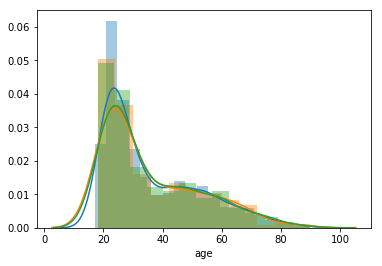

In [91]:
sns.distplot(train_y.age)
sns.distplot(test_y.age)
sns.distplot(val_y.age)

A few basic models
===========
* Basic linear model
* Basic non-linear model
* Basic cross-decomposition model
* A lil grid search

More advanced models
===========
* KFold learning
* Cluster-based prediction
* Heteroscedastic model


In [93]:
# Prepare inputs
X = pandas.DataFrame(train_x, copy=True)
X.loc[:,'gender'] = [1 if x == 'm' else 2 for x in train_y.gender.values]
X.loc[:,'site'] = train_y.site.values
X.drop('subject_ID',axis=1,inplace=True)
y = train_y.age.values

tX = pandas.DataFrame(test_x, copy=True)
tX.loc[:,'gender'] = [1 if x == 'm' else 2 for x in test_y.gender.values]
tX.loc[:,'site'] = test_y.site.values
tX.drop('subject_ID',axis=1,inplace=True)
ty = test_y.age.values



### Basic Linear

svr 10-fold validation results


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


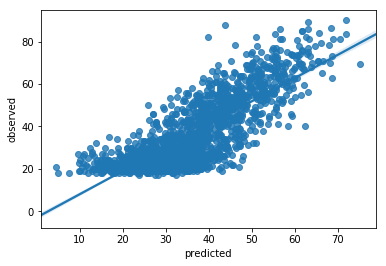

ACCURACY: r2 = 0.6559331736012267, rho = 0.776104917279626, mae = 7.591412007118501
svr Validation test results


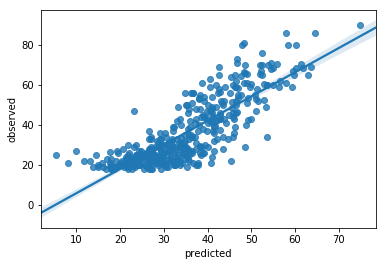

ACCURACY: r2 = 0.6854146038868398, rho = 0.8168122178434086, mae = 7.163254099201961


/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


lasso 10-fold validation results


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


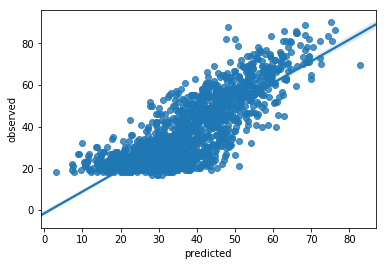

ACCURACY: r2 = 0.6725202071188402, rho = 0.7764922246287772, mae = 7.364689264063273
lasso Validation test results


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


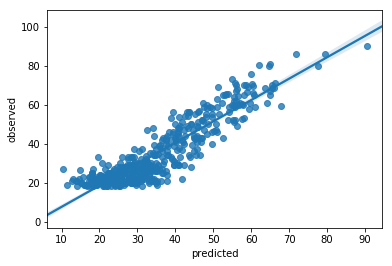

ACCURACY: r2 = 0.8202525528645568, rho = 0.8632450191396563, mae = 5.663378554010828


In [52]:

mod_l2 = svm.SVR(kernel='linear')
mod_l1 = linear_model.LassoCV(random_state=123)
for name,model in dict(zip(['svr','lasso'],[mod_l2,mod_l1])).items():
    # train model
    preds = model_selection.cross_val_predict(model,X,y,
                                              groups=train_y.age_bin.values)
    print('{} 10-fold validation results'.format(name))
    r2 = stats.pearsonr(preds,y)[0]**2
    rho = stats.spearmanr(preds,y)[0]
    mae = mean_absolute_error(preds,y)
    sns.regplot(preds,y)
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.show()
    print('ACCURACY: r2 = {}, rho = {}, mae = {}'.format(r2,rho, mae))
    
    # retrain with all data
    mod = model.fit(tX,ty)
    
    # test
    test_pred = mod.predict(tX)
    print('{} Validation test results'.format(name))
    r2 = stats.pearsonr(test_pred,ty)[0]**2
    rho = stats.spearmanr(test_pred,ty)[0]
    mae = mean_absolute_error(test_pred, ty)
    sns.regplot(test_pred,ty)
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.show()
    print('ACCURACY: r2 = {}, rho = {}, mae = {}'.format(r2,rho,mae))
    
    
    

### BASIC NON-LINEAR

svr 10-fold validation results


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


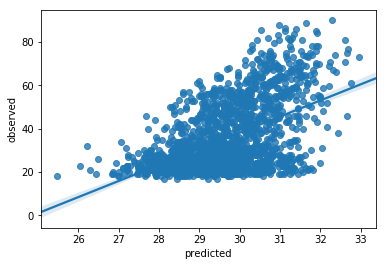

ACCURACY: r2 = 0.2561835495059643, rho = 0.4415414567361882
svr Validation test results


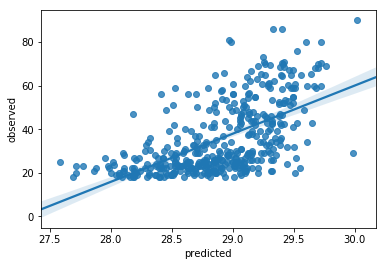

ACCURACY: r2 = 0.3492722500547423, rho = 0.6195729890099915
RandForest 10-fold validation results


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


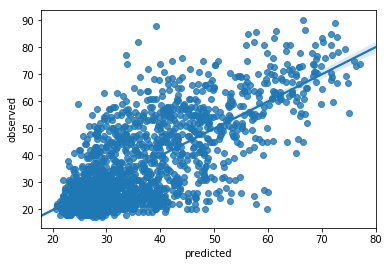

ACCURACY: r2 = 0.5436714659559887, rho = 0.6690303428558295
RandForest Validation test results


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


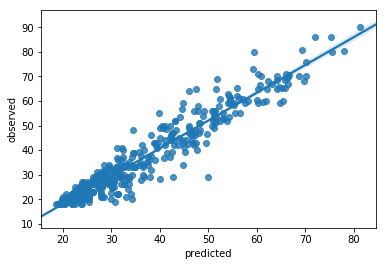

ACCURACY: r2 = 0.9207331623416688, rho = 0.9365538224085793


In [56]:
mod_rbf = svm.SVR(kernel='poly',degree=2)
mod_rf = ensemble.RandomForestRegressor(n_estimators=10)
for name,model in dict(zip(['svr','RandForest'],[mod_rbf,mod_rf])).items():
    # train model
    preds = model_selection.cross_val_predict(model,X,y,
                                              groups=train_y.age_bin.values)
    print('{} 10-fold validation results'.format(name))
    r2 = stats.pearsonr(preds,y)[0]**2
    rho = stats.spearmanr(preds,y)[0]
    mae = mean_absolute_error(preds,y)
    sns.regplot(preds,y)
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.show()
    print('ACCURACY: r2 = {}, rho = {}, mae = {}'.format(r2,rho,mae))
    
    # retrain with all data
    mod = model.fit(tX,ty)
    
    # test
    test_pred = mod.predict(tX)
    print('{} Validation test results'.format(name))
    r2 = stats.pearsonr(test_pred,ty)[0]**2
    rho = stats.spearmanr(test_pred,ty)[0]
    mae = mean_absolute_error(test_pred,ty)
    sns.regplot(test_pred,ty)
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.show()
    print('ACCURACY: r2 = {}, rho = {}, mae = {}'.format(r2,rho,mae))
    

### Basic cross-decomposition model

In [95]:
## Basic cross-decomposition model
Xpca = pandas.DataFrame(train_x,copy=True)
Xpca.drop('subject_ID',axis=1,inplace=True)
pcamod = decomposition.PCA(n_components=100).fit(Xpca)
Xpca = pandas.DataFrame(pcamod.transform(Xpca),
                       index = Xpca.index)
Xpca.loc[:,'gender'] = [1 if x == 'm' else 2 for x in train_y.gender.values]
Xpca.loc[:,'site'] = train_y.site.values


tXpca = pandas.DataFrame(test_x, copy=True)
tXpca.drop('subject_ID',axis=1,inplace=True)
tXpca = pandas.DataFrame(pcamod.transform(tXpca))
tXpca.loc[:,'gender'] = [1 if x == 'm' else 2 for x in test_y.gender.values]
tXpca.loc[:,'site'] = test_y.site.values


pls 10-fold validation results


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


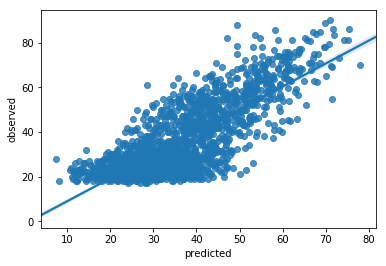

ACCURACY: r2 = 0.625793702296158, rho = 0.7276538108588597, mae = 7.910289152417474
pls Validation test results


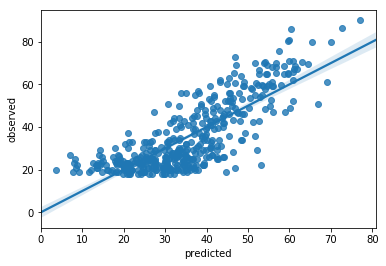

ACCURACY: r2 = 0.6415113892699964, rho = 0.762548344861611, mae = 7.993016244813591
cca 10-fold validation results


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


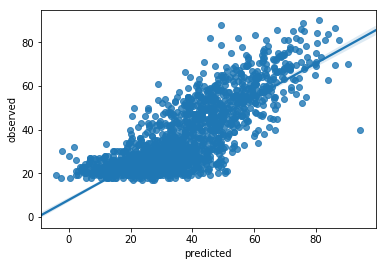

ACCURACY: r2 = 0.6499518558919462, rho = 0.768329543549611, mae = 8.08799671925011
cca Validation test results


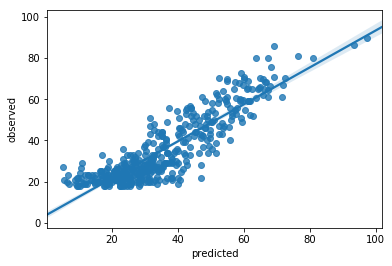

ACCURACY: r2 = 0.7762322360100901, rho = 0.8386898361415305, mae = 6.354114321438795


In [101]:
mod_pls = cross_decomposition.PLSRegression(n_components=1)
mod_cca = cross_decomposition.CCA(n_components=1)
for name,model in dict(zip(['pls','cca'],[mod_pls,mod_cca])).items():
    # train model
    preds = model_selection.cross_val_predict(model,Xpca,y,
                                              groups=train_y.age_bin.values)
    print('{} 10-fold validation results'.format(name))
    r2 = stats.pearsonr(preds[:,0],y)[0]**2
    rho = stats.spearmanr(preds[:,0],y)[0]
    mae = mean_absolute_error(preds[:,0],y)
    sns.regplot(preds[:,0],y)
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.show()
    print('ACCURACY: r2 = {}, rho = {}, mae = {}'.format(r2,rho, mae))
    
    # retrain with all data
    mod = model.fit(tXpca,ty)

    # test
    test_pred = mod.predict(tXpca)
    print('{} Validation test results'.format(name))
    r2 = stats.pearsonr(test_pred[:,0],ty)[0]**2
    rho = stats.spearmanr(test_pred[:,0],ty)[0]
    mae = mean_absolute_error(test_pred[:,0],ty)
    sns.regplot(test_pred[:,0],ty)
    plt.xlabel('predicted')
    plt.ylabel('observed')
    plt.show()
    print('ACCURACY: r2 = {}, rho = {}, mae = {}'.format(r2,rho,mae))
    

### Basic Grid-Search

In [115]:
params1 = {'loss': ['squared_loss','huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
          'penalty': ['none', 'l2', 'l1'],
          'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100]} 
params2 = {'loss': ['squared_loss','huber', 'epsilon_insensitive', 'squared_epsilon_insensitive'],
          'penalty': ['elasticnet'],
          'alpha': [0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
          'l1_ratio': [0.05,0.1,0.15,0.2,0.3,0.5]} 

In [116]:
selector = model_selection.GridSearchCV(linear_model.SGDRegressor(random_state=123),[params1,params2],cv=10)

/home/users/jvogel/anaconda2/envs/py3/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:84: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


In [117]:
mod = selector.fit(X,y,groups=train_y.age_bin.values)

SGD Grid Search 10-fold validation results


/home/users/jvogel/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


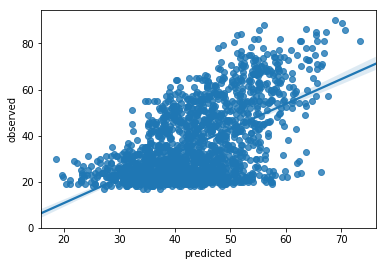

ACCURACY: r2 = 0.3396810742906361, rho = 0.5031716519228245, mae = 12.823155853023538
SGD Grid Search Validation test results


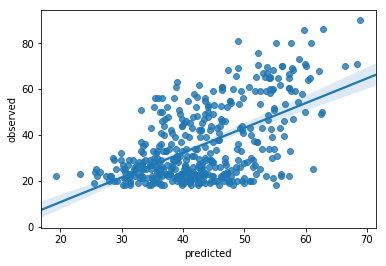

ACCURACY: r2 = 0.3225527751045486, rho = 0.4574830033762947, mae = 13.082795769914933


In [121]:
name = 'SGD Grid Search'
preds = mod.predict(X)
print('{} 10-fold validation results'.format(name))
r2 = stats.pearsonr(preds,y)[0]**2
rho = stats.spearmanr(preds,y)[0]
mae = mean_absolute_error(preds,y)
sns.regplot(preds,y)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.show()
print('ACCURACY: r2 = {}, rho = {}, mae = {}'.format(r2,rho, mae))

# test
test_pred = mod.predict(tX)
print('{} Validation test results'.format(name))
r2 = stats.pearsonr(test_pred,ty)[0]**2
rho = stats.spearmanr(test_pred,ty)[0]
mae = mean_absolute_error(test_pred,ty)
sns.regplot(test_pred,ty)
plt.xlabel('predicted')
plt.ylabel('observed')
plt.show()
print('ACCURACY: r2 = {}, rho = {}, mae = {}'.format(r2,rho,mae))
